# Comparing energy vs denoiser model

In [68]:
%load_ext autoreload
%autoreload 2

import numpy as np
from matplotlib import pyplot as plt
import torch

from tqdm.notebook import tqdm, trange

from main import *

params = {
      'text.usetex': True,
      'font.family': 'sans serif'
}
matplotlib.rcParams.update(params)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Load two models

In [65]:
def load_exp(name, step="last", log=True, dataloaders=False):
    """ Load an experiment with a given name. step can be an integer, "best", or "last" (default). """
    exp_dir = Path("models") / name

    with open(exp_dir / "args.json") as f:
        args_dict = json.load(f)

    ctx = TrainingContext(**args_dict, step=step, key_remap=None, seed=None, dataloaders=dataloaders, writer=False)
    if log:
        print(f"{name}: retrieved model at step {ctx.step} and test loss {ctx.test_perf.loss:.2e}")

    # Disable DataParallel (needed for Hessian computation)
    ctx.model.network = ctx.model.network.module

    # Put in eval mode and disable gradients with respect to all parameters.
    ctx.model.eval()
    for p in ctx.model.parameters():
        p.requires_grad = False

    # Normalize energies.
    ctx.network.network.log_normalization_constant = ctx.test_perf.log_normalization_constant

    return ctx

ctxs = {
    "energy": load_exp("finalclean_imagenet64_color_lr0.0005_1Msteps10decays"),
    "denoiser": load_exp("finalclean_imagenet64_color_denoiser_psco_lr0.0005_1Msteps10decays"),
}
default_ctx = ctxs["energy"]
device = default_ctx.device
dataset_info = default_ctx.dataset_info
d = dataset_info.dimension

finalclean_imagenet64_color_lr0.0005_1Msteps10decays: retrieved model at step 1000000 and test loss 4.22e-01
finalclean_imagenet64_color_denoiser_psco_lr0.0005_1Msteps10decays: retrieved model at step 1000000 and test loss 4.11e-01


/mnt/home/fguth/venvs/default/lib/python3.11/site-packages/torchvision/transforms/v2/_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


## Compare denoising performance

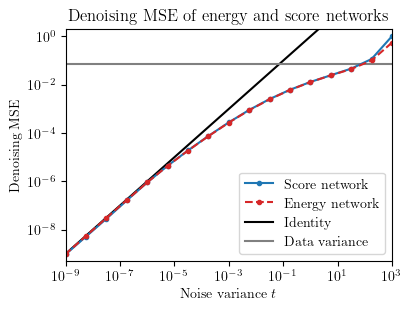

In [69]:
t = default_ctx.test_perf.noise_levels.variance.cpu()
energy_mse = ctxs["energy"].test_perf.denoising_errors.mse.cpu()
denoiser_mse = ctxs["denoiser"].test_perf.denoising_errors.mse.cpu()

plt.figure(figsize=(4, 3), layout="constrained")
plt.plot(t, denoiser_mse, color="tab:blue", marker=".", label="Score network")
plt.plot(t, energy_mse, color="tab:red", linestyle="dashed", marker=".", label="Energy network")
plt.plot(t, t, color="black", label="Identity", zorder=-1)
plt.plot(t, torch.full_like(t, default_ctx.dataset_info.variance), color="gray", label="Data variance", zorder=-1)
plt.xlabel("Noise variance $t$")
plt.xscale("log")
plt.xlim(1e-9, 1e3)
# plt.xticks(10. ** np.arange(-9, 4), fontsize=8)
plt.ylabel("Denoising MSE")
plt.yscale("log")
plt.ylim(5e-10, 2e0)
plt.title("Denoising MSE of energy and score networks")
plt.legend()
plt.savefig("outputs/denoising_performance.pdf", transparent=True, bbox_inches="tight", pad_inches=0)
plt.show()

In [64]:
f = lambda x, p, t: print(" & ".join([t] + [f"${y:.{p}f}$" for y in -10 * torch.log10(torch.flip(x, [0])[::2])]) + r" \\")
f(t, 0, "Noise variance")
print(r"\midrule")
f(denoiser_mse, 2, "Score network")
f(energy_mse, 2, "Energy network")

Noise variance & $90$ & $75$ & $60$ & $45$ & $30$ & $15$ & $-0$ & $-15$ & $-30$ \\
\midrule
Score network & $90.20$ & $75.47$ & $60.43$ & $47.19$ & $35.58$ & $25.92$ & $18.84$ & $13.31$ & $-0.11$ \\
Energy network & $90.09$ & $75.17$ & $60.45$ & $47.25$ & $35.67$ & $26.01$ & $18.88$ & $13.48$ & $2.53$ \\
